# Rock Paper Scissors


## Google Colab Setup

this is just all the stuff to run our code in google Colab

In [172]:
# uncomment when run in GoogleColab

#!pip install torchmetrics
#from google.colab import drive
#drive.mount('/content/gdrive')
#import sys
#sys.path.append('/content/gdrive/My Drive/Uni/Project Deep Learning/Shifumi_ds/myPackages')
#import pytorch_toolkit

In [173]:
# Connect to Google drive, so I can import modules from it into my workspace
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = False

import os

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    grive_path = os.path.join(gdrive_mount_point, "My Drive/")
    print('Your Google Drive is mounted at ', grive_path)
    COLAB_NOTEBOOKS_PATH = os.path.join(grive_path, "Colab Notebooks/")
    
    if os.path.exists(COLAB_NOTEBOOKS_PATH):    
        # display list of files
        #!ls '/content/drive/My Drive/Colab Notebooks/'

        # append our Google Drive folder to module search 
        # **NOTE:** comment this line out if you are NOT running this notebook on Google Colab
        import sys
        #sys.path.append("/content/drive/My Drive/Colab Notebooks/")
        pyt_path = os.path.join(COLAB_NOTEBOOKS_PATH, 'pytorch')
        sys.path.append(pyt_path)
        print('You Pytorch Colab notebooks are available at ', pyt_path)
        print('NOTE: {} is appended to sys.path!'.format(pyt_path))
        # and test it
        import pytorch_toolkit as pyt
        MODEL_SAVE_DIR = os.path.join(pyt_path, 'model_states')
    else:
        raise IOError("Unable to mount Google Drive!")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

assert os.path.exists(MODEL_SAVE_DIR)
print('MODEL_SAVE_DIR = %s' % MODEL_SAVE_DIR)

MODEL_SAVE_DIR = ./model_states


In [174]:
import warnings
warnings.filterwarnings('ignore')

import os, sys, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import glob

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn')
sns.set_style('darkgrid')
sns.set_context('notebook',font_scale=1.10)

# Pytorch imports
import torch
gpu_available = torch.cuda.is_available()
print('Using Pytorch version: %s. GPU %s available' % (torch.__version__, "IS" if gpu_available else "is NOT"))
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from keras_preprocessing.image import *
# My helper functions for training/evaluating etc.
#import pytorch_toolkit as pytk

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    #torch.backends.cudnn.enabled = False

Using Pytorch version: 1.13.1. GPU is NOT available


## ModelGeneration and Training

### Setup

Before we start with the training we want to define some global setup variables:

In [175]:
CLASSES = ['rock', 'paper', 'scissors']
# the size of the images we want to feed to the model
model_input_size= (64,64)
batch_size= 64

### Loading the already preprocessed Data

In [176]:
def get_data(image_paths, target_size=model_input_size):
    """ resizes the images to a target size"""
    images, labels = [], []
    for image_path in image_paths:
        image = load_img(image_path, target_size=target_size, color_mode='grayscale')
        image = img_to_array(image)
        label_name = image_path.split(os.path.sep) [-2]
        label = CLASSES.index(label_name)
        label = np.array(label).astype('int32')
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

In [177]:
file_pattern = '/home/divingsoup/Documents/Uni-Bamberg/Semester5/ProjectXDeepLearning/shifumi/DataEng/datasets/combined/*/*.png'
dataset_paths = [*glob.glob(str(file_pattern))]
random.shuffle(dataset_paths)
images, labels = get_data(dataset_paths)
print(f"images.shape: {images.shape} - labels.shape: {labels.shape}")

images.shape: (7578, 64, 64, 1) - labels.shape: (7578,)


In [178]:
dataset_paths[:10]

['/home/divingsoup/Documents/Uni-Bamberg/Semester5/ProjectXDeepLearning/shifumi/DataEng/datasets/combined/paper/3__paper06-021.png',
 '/home/divingsoup/Documents/Uni-Bamberg/Semester5/ProjectXDeepLearning/shifumi/DataEng/datasets/combined/paper/0__glu_26.png',
 '/home/divingsoup/Documents/Uni-Bamberg/Semester5/ProjectXDeepLearning/shifumi/DataEng/datasets/combined/rock/0__glu_24.png',
 '/home/divingsoup/Documents/Uni-Bamberg/Semester5/ProjectXDeepLearning/shifumi/DataEng/datasets/combined/rock/0__glu_161.png',
 '/home/divingsoup/Documents/Uni-Bamberg/Semester5/ProjectXDeepLearning/shifumi/DataEng/datasets/combined/paper/0__glu_493.png',
 '/home/divingsoup/Documents/Uni-Bamberg/Semester5/ProjectXDeepLearning/shifumi/DataEng/datasets/combined/scissors/0__glu_534.png',
 '/home/divingsoup/Documents/Uni-Bamberg/Semester5/ProjectXDeepLearning/shifumi/DataEng/datasets/combined/rock/2__A2j94231CiW6OKA0.png',
 '/home/divingsoup/Documents/Uni-Bamberg/Semester5/ProjectXDeepLearning/shifumi/DataEn

In [179]:
np.bincount(labels.astype('int32')), labels[:10]

(array([2528, 2490, 2560]), array([1, 1, 0, 0, 1, 2, 0, 2, 2, 2], dtype=int32))

### Building the model

The following section builds the Model

In [180]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, activate_dropout=True, dropout_probability=0.5):
        super(MyModel, self).__init__()

        self.activate_dropout = activate_dropout
        self.dropout_probability = dropout_probability

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2,2)
        self.dropout1 = nn.Dropout(self.dropout_probability)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2,2)
        self.dropout2 = nn.Dropout(self.dropout_probability)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.AdaptiveMaxPool2d(2)
        self.dropout3 = nn.Dropout(self.dropout_probability)

        # self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=1)
        # self.bn2 = nn.BatchNorm2d(128)
        # self.pool2 = nn.MaxPool2d(2,2)
        # self.dropout2 = nn.Dropout(self.dropout_probability)
        #
        # self.conv3 = nn.Conv2d(128, 128, kernel_size=5, padding=1)
        # self.bn3 = nn.BatchNorm2d(128)
        # self.pool3 = nn.AdaptiveMaxPool2d(2)
        # self.dropout3 = nn.Dropout(self.dropout_probability)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*2*2, 500)
        # self.fc1 = nn.Linear(128*2*2, 1000)
        # self.fc1 = nn.Linear(1000, 500)
        self.dropout4 = nn.Dropout(self.dropout_probability)
        self.fc2 = nn.Linear(500, 3)
        self.show_shapes()

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.bn1(x)
        x = self.pool1(x)
        if self.activate_dropout:
            x = self.dropout1(x)

        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.bn2(x)
        x = self.pool2(x)
        if self.activate_dropout:
            x = self.dropout2(x)

        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.bn3(x)
        x = self.pool3(x)
        if self.activate_dropout:
            x = self.dropout3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        if self.activate_dropout:
            x = self.dropout4(x)

        x = self.fc2(x)
        return x

    def show_shapes(self):
        print("Layer shapes:")
        print("\tConv1: ", self.conv1.weight.shape)
        print("\tBN1: ", self.bn1.weight.shape)
        print("\tPool1: ", self.pool1.kernel_size)
        if self.activate_dropout:
            print("\tDropout1: ", self.dropout1.p)
        print("\tConv2: ", self.conv2.weight.shape)
        print("\tBN2: ", self.bn2.weight.shape)
        print("\tPool2: ", self.pool2.kernel_size)
        if self.activate_dropout:
            print("\tDropout2: ", self.dropout2.p)
        print("\tConv3: ", self.conv3.weight.shape)
        print("\tBN3: ", self.bn3.weight.shape)
        #print("\tPool3: ", self.pool3.kernel_size)
        if self.activate_dropout:
            print("\tDropout3: ", self.dropout3.p)
        print("\tFlatten: ")
        print("\tFC1: ", self.fc1.weight.shape)
        if self.activate_dropout:
            print("\tDropout4: ", self.dropout4.p)
        print("\tFC2: ", self.fc2.weight.shape)

In [181]:
from sklearn.model_selection import train_test_split

# split dataset into train/test sets in 70:30 ration
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, 
                                                    random_state=SEED, stratify=labels)
# split the test set into cross-val & test datasets in 80:20 rstio
# NOTE: Andrew Ng recommends that, if possible, the test & cv datasets should be drawn
# from the same sample
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3, 
                                                random_state=SEED, stratify=y_test)

print(f"X_train.shape: {X_train.shape} - y_train.shape: {y_train.shape} - class dist: {np.bincount(y_train)}\n" +
      f"X_val.shape: {X_val.shape} - y_val.shape: {y_val.shape} - class dist: {np.bincount(y_val)}\n" +
      f"X_test.shape: {X_test.shape} - y_test.shape: {y_test.shape} - class dist: {np.bincount(y_test)}") 

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_val = y_val.astype('float32')

X_train.shape: (5304, 64, 64, 1) - y_train.shape: (5304,) - class dist: [1769 1743 1792]
X_val.shape: (1591, 64, 64, 1) - y_val.shape: (1591,) - class dist: [531 523 537]
X_test.shape: (683, 64, 64, 1) - y_test.shape: (683,) - class dist: [228 224 231]


In [182]:
# define a dataset for Pytorch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class RPSDataset(Dataset):
    def __init__(self, x, y, transforms=None):
        self.x = x
        self.y = torch.LongTensor(y)
        self.transforms = transforms

    def __len__(self):
        return len(self.x)

    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        if self.transforms is not None:
            x = self.transforms(x)
        return x, y

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(0, shear=0.2),         # random shear 0.2
    transforms.RandomAffine(0, scale=(0.8, 1.2)),  # random zoom 0.2
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])
    
image_transforms = transforms.Compose([
    transforms.ToTensor()   
])

In [183]:
train_dataset = RPSDataset(X_train, y_train, train_transforms)
val_dataset = RPSDataset(X_val, y_val, image_transforms)
test_dataset = RPSDataset(X_test, y_test, image_transforms)

images.shape: (64, 1, 64, 64) - labels.shape: (64,)


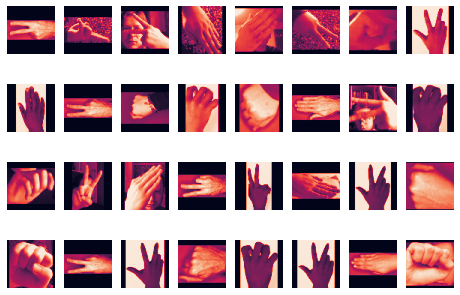

In [184]:
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
data_iter = iter(testloader)
sample_images, sample_labels = next(data_iter)
sample_images, sample_labels = sample_images.cpu().numpy(), sample_labels.cpu().numpy()
print(f"images.shape: {sample_images.shape} - labels.shape: {sample_labels.shape}")

#plt.figure(figsize=(5,5))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    image = sample_images[i]
    #print(f"images[{i}].shape: {image.shape} ")
    image = image.transpose((1,2,0))
    #print(f" - AP: images[{i}].shape: {image.shape}")
    #plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(image.squeeze())
    plt.axis('off')
plt.show()
plt.close()

images.shape: (64, 1, 64, 64) - labels.shape: (64,)


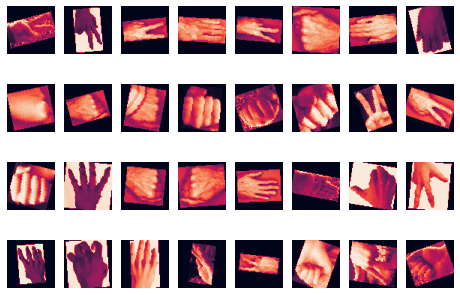

In [185]:
testloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
data_iter = iter(testloader)
sample_images, sample_labels = next(data_iter)
sample_images, sample_labels = sample_images.cpu().numpy(), sample_labels.cpu().numpy()
print(f"images.shape: {sample_images.shape} - labels.shape: {sample_labels.shape}")

#plt.figure(figsize=(5,5))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    image = sample_images[i]
    #print(f"images[{i}].shape: {image.shape} ")
    image = image.transpose((1,2,0))
    #print(f" - AP: images[{i}].shape: {image.shape}")
    #plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(image.squeeze())
    plt.axis('off')
plt.show()
plt.close()

In [186]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model, loss function, and optimizer
model = MyModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validationloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


def test_accuracy(testloader):
    # Test the model on the test dataset
    outcome = {}
    with torch.no_grad():
        correct = 0
        total = 0
        class_correct = [0. for i in range(len(CLASSES))]
        class_total = [0. for i in range(len(CLASSES))]
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            c = (predicted == labels).squeeze()
            for i in range(len(c)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
        print(f'Accuracy of the network on the test set: {100 * correct / total}%')
        outcome['total'] = 100 * correct / total
        for i in range(len(CLASSES)):
            if class_total[1]>0:
                print(f'Accuracy of {CLASSES[i]} : {100 * class_correct[i] / class_total[i]}%')
                outcome[CLASSES[i]] = 100 * class_correct[i] / class_total[i]
            else:
                print(f'Accuracy of {CLASSES[i]} : could not be measured, no test images%')
    return outcome

def train(epoches, training_data, val_data):
    hist=[]
    for epoch in range(epoches):
        running_loss = 0.0
        for i, data in enumerate(training_data, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1} loss: {running_loss / len(trainloader)}')
        hist.append(test_accuracy(val_data))
    return hist


Layer shapes:
	Conv1:  torch.Size([32, 1, 5, 5])
	BN1:  torch.Size([32])
	Pool1:  2
	Dropout1:  0.5
	Conv2:  torch.Size([64, 32, 5, 5])
	BN2:  torch.Size([64])
	Pool2:  2
	Dropout2:  0.5
	Conv3:  torch.Size([64, 64, 5, 5])
	BN3:  torch.Size([64])
	Dropout3:  0.5
	Flatten: 
	FC1:  torch.Size([500, 256])
	Dropout4:  0.5
	FC2:  torch.Size([3, 500])


In [187]:
# load existing model
#model = torch.load('./model_states/pytk_rock_paper_scissors_10epoches.pt')
#model = torch.load('./model_states/model_10e.pt')

#model = MyModel()
#model.load_state_dict(torch.load('./model_states/model_10e.pt'))

In [188]:
#train new model
hist = train(epoches=100, training_data= trainloader, val_data= validationloader)

Epoch 1 loss: 1.0101356736148697
Accuracy of the network on the test set: 58.516656191074794%
Accuracy of rock : 79.09604519774011%
Accuracy of paper : 47.22753346080306%
Accuracy of scissors : 49.16201117318436%
Epoch 2 loss: 0.7865380350365696
Accuracy of the network on the test set: 62.41357636706474%
Accuracy of rock : 88.70056497175142%
Accuracy of paper : 14.149139579349905%
Accuracy of scissors : 83.42644320297951%
Epoch 3 loss: 0.728306139089975
Accuracy of the network on the test set: 63.670647391577624%
Accuracy of rock : 86.62900188323917%
Accuracy of paper : 48.565965583174%
Accuracy of scissors : 55.679702048417134%
Epoch 4 loss: 0.6776453195566154
Accuracy of the network on the test set: 71.5901948460088%
Accuracy of rock : 88.70056497175142%
Accuracy of paper : 55.06692160611855%
Accuracy of scissors : 70.76350093109869%
Epoch 5 loss: 0.6025625312902841
Accuracy of the network on the test set: 74.16719044626021%
Accuracy of rock : 81.35593220338983%
Accuracy of paper : 6

In [190]:
# Define the test dataloader
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print('testing against the test dataset:')
test_accuracy(testloader)

testing against the test dataset:
Accuracy of the network on the test set: 93.8506588579795%
Accuracy of rock : 96.9298245614035%
Accuracy of paper : 88.39285714285714%
Accuracy of scissors : 96.1038961038961%


{'total': 93.8506588579795,
 'rock': 96.9298245614035,
 'paper': 88.39285714285714,
 'scissors': 96.1038961038961}

In [189]:
# save the model
torch.save(model.state_dict(), './model_states/model_100e.pt')

In [218]:
# test the model against unknown dataset
print('testing against the unknown dataset:')
file_pattern_unknown_images = f'/home/divingsoup/Documents/Uni-Bamberg/Semester5/ProjectXDeepLearning/shifumi/DataEng/datasets/unseen_testdata/*/*.png'
dataset_paths_unknown_images = [*glob.glob(str(file_pattern_unknown_images))]
images_unknown, labels_unknown = get_data(dataset_paths_unknown_images)
unknown_ds = RPSDataset(images_unknown, labels_unknown, image_transforms)
test_accuracy(DataLoader(unknown_ds, batch_size=batch_size, shuffle=False))

testing against the unknown dataset:
Accuracy of the network on the test set: 76.27118644067797%
Accuracy of rock : 89.47368421052632%
Accuracy of paper : 65.0%
Accuracy of scissors : 75.0%


{'total': 76.27118644067797,
 'rock': 89.47368421052632,
 'paper': 65.0,
 'scissors': 75.0}

In [226]:
# test the model against unknown dataset - random distortion
print('testing against the randomly distorted dataset:')
file_pattern_unknown_images = f'/home/divingsoup/Documents/Uni-Bamberg/Semester5/ProjectXDeepLearning/shifumi/DataEng/datasets/unseen_testdata_randomNoise/*/*.png'
dataset_paths_unknown_images = [*glob.glob(str(file_pattern_unknown_images))]
images_unknown, labels_unknown = get_data(dataset_paths_unknown_images)
rndDis_ds = RPSDataset(images_unknown, labels_unknown, image_transforms)
test_accuracy(DataLoader(rndDis_ds, batch_size=batch_size, shuffle=False))

testing against the randomly distorted dataset:
Accuracy of the network on the test set: 40.67796610169491%
Accuracy of rock : 21.05263157894737%
Accuracy of paper : 45.0%
Accuracy of scissors : 55.0%


{'total': 40.67796610169491,
 'rock': 21.05263157894737,
 'paper': 45.0,
 'scissors': 55.0}

In [230]:
# test the model against unknown dataset - gaussian distortion
print('testing against the dataset with gaussian distortion:')
file_pattern_unknown_images = f'/home/divingsoup/Documents/Uni-Bamberg/Semester5/ProjectXDeepLearning/shifumi/DataEng/datasets/unseen_testdata_gaussianNoise/*/*.png'
dataset_paths_unknown_images = [*glob.glob(str(file_pattern_unknown_images))]
images_unknown, labels_unknown = get_data(dataset_paths_unknown_images)
gaussDis_ds = RPSDataset(images_unknown, labels_unknown, image_transforms)
test_accuracy(DataLoader(gaussDis_ds, batch_size=batch_size, shuffle=False))

testing against the dataset with gaussian distortion:
Accuracy of the network on the test set: 57.6271186440678%
Accuracy of rock : 47.36842105263158%
Accuracy of paper : 55.0%
Accuracy of scissors : 70.0%


{'total': 57.6271186440678,
 'rock': 47.36842105263158,
 'paper': 55.0,
 'scissors': 70.0}

In [23]:
MODEL_SAVE_PATH = './model_states/pytk_rock_paper_scissors_100epoches.pt'
#model.save(MODEL_SAVE_PATH)

# TODO go deeper -> use one more conv layer and one more hidden layer, and check if the Adaptive Layer fucked something up
# TODO train on all of our data and use AI-Proj-M-validation_set_pp_01_grey as test-set
# TODO check the input channels of the convolutional layers

## Evaluation

now there comes the evaluation part

In [24]:
def get_all_predictions(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels =batch
        
        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [29]:
with torch.no_grad():
    prediction_loader = DataLoader(train_dataset, batch_size= 1000)
    train_preds = get_all_predictions(model, prediction_loader)

In [42]:
print(train_preds.shape)
print(train_preds.argmax(dim=1))

torch.Size([5304, 3])
tensor([1, 1, 2,  ..., 0, 1, 1])


In [51]:
train_targets = torch.tensor(y_train).type(torch.int32)
print(train_targets)

tensor([2, 2, 2,  ..., 0, 0, 1], dtype=torch.int32)


In [53]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(train_targets, train_preds.argmax(dim=1))
cm

array([[1573,  112,   84],
       [  98, 1442,  203],
       [  78,  286, 1428]])

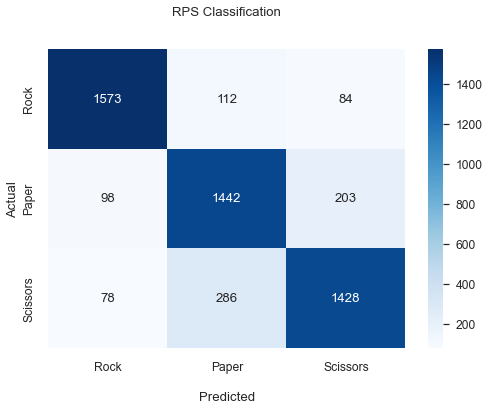

In [67]:
# Print the confusion matrix using Matplotlib

ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')

ax.set_title('RPS Classification\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Rock','Paper', 'Scissors'])
ax.yaxis.set_ticklabels(['Rock','Paper', 'Scissors'])

## Display the visualization of the Confusion Matrix.
plt.show()

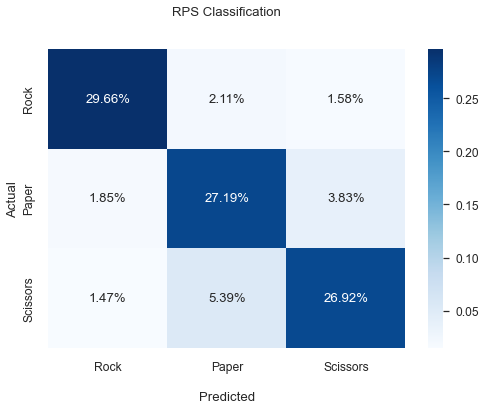

In [68]:
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('RPS Classification\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Rock','Paper', 'Scissors'])
ax.yaxis.set_ticklabels(['Rock','Paper', 'Scissors'])

## Display the visualization of the Confusion Matrix.
plt.show()

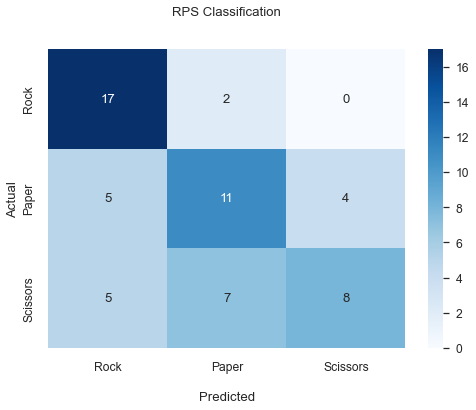

In [109]:
#confusion matrix unseen testset - no distortion

with torch.no_grad():
    prediction_loader = DataLoader(unknown_ds, batch_size= 1000)
    train_preds = get_all_predictions(model, prediction_loader)


unseenLoader = DataLoader(unknown_ds, batch_size=batch_size, shuffle=False)

test_targets_list = []
for inputs, targets in unseenLoader:
    test_targets_list.append(targets)

test_targets = test_targets_list[0]

cm = confusion_matrix(test_targets, train_preds.argmax(dim=1))

# Print the confusion matrix using Matplotlib
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')

ax.set_title('RPS Classification\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Rock','Paper', 'Scissors'])
ax.yaxis.set_ticklabels(['Rock','Paper', 'Scissors'])

## Display the visualization of the Confusion Matrix.
plt.show()

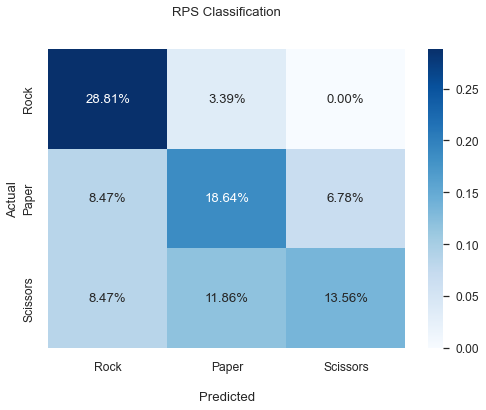

In [110]:
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('RPS Classification\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Rock','Paper', 'Scissors'])
ax.yaxis.set_ticklabels(['Rock','Paper', 'Scissors'])

## Display the visualization of the Confusion Matrix.
plt.show()

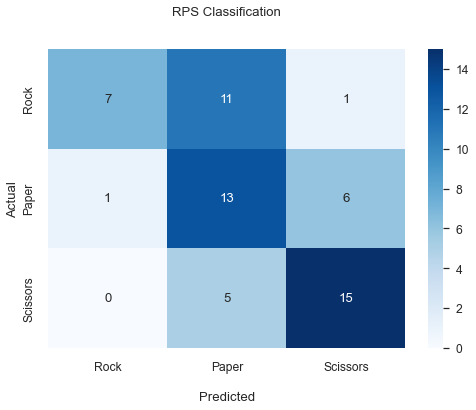

In [170]:
#confusion matrix (unseen) testset - Gaussian distortion

with torch.no_grad():
    prediction_loader = DataLoader(gaussDis_ds, batch_size= 1000)
    train_preds = get_all_predictions(model, prediction_loader)


gaussLoader = DataLoader(gaussDis_ds, batch_size=batch_size, shuffle=False)

test_targets_list = []
for inputs, targets in gaussLoader:
    test_targets_list.append(targets)

test_targets = test_targets_list[0]

cm = confusion_matrix(test_targets, train_preds.argmax(dim=1))

# Print the confusion matrix using Matplotlib
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')

ax.set_title('RPS Classification\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Rock','Paper', 'Scissors'])
ax.yaxis.set_ticklabels(['Rock','Paper', 'Scissors'])

## Display the visualization of the Confusion Matrix.
plt.show()

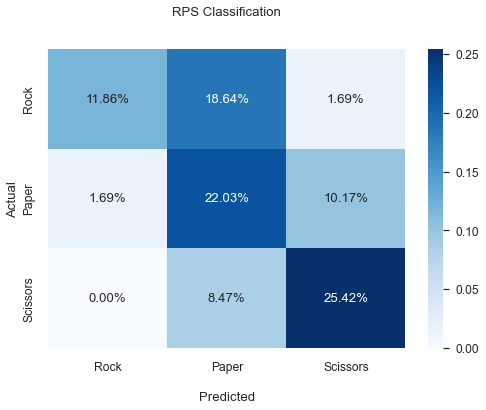

In [171]:
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('RPS Classification\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Rock','Paper', 'Scissors'])
ax.yaxis.set_ticklabels(['Rock','Paper', 'Scissors'])

## Display the visualization of the Confusion Matrix.
plt.show()